In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
# from utils import get_data
from utils1 import get_data


  0%|          | 0/1 [00:00<?, ?it/s]/Users/vimohr/ETH_Datathon_2025/utils1.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col_name] = new_df[base_col].shift(lag)
/Users/vimohr/ETH_Datathon_2025/utils1.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col_name] = new_df[base_col].shift(lag)
/Users/vimohr/ETH_Datathon_2025/utils1.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

(13125, 7399)
(13125, 745)



/Users/vimohr/ETH_Datathon_2025/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/vimohr/ETH_Datathon_2025/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


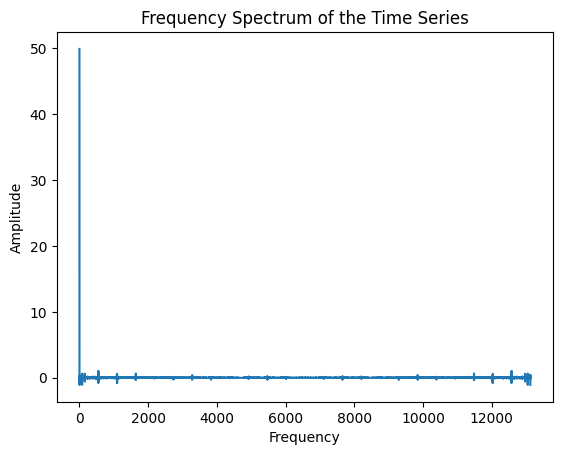

In [2]:
# Assuming get_data is a function that returns the data in the correct format.
Xs, ys, times, _ = get_data('ES', [1], demand=[i for i in range(1, 2*24*365//12+1)]+[i for i in range(10*24*365//12+1, 24*365+1)], temp=[0, 1, 24, 24*7, 24*365] + [-i-1 for i in range(31*24)], spv=[0, 1, 24, 24*7, 24*365] + [-i-1 for i in range(31*24)], rollout_values=[-i-1 for i in range(31*24)], n_futures=31*24)

X = Xs[0]  # Assuming X is a 2D numpy array
y = ys[0]  # Reshaping y to be a 2D column vector

X_predict = X[len(y):]
X = X[:len(y)]

# print(X)
# print(y)

print(X.shape)
print(y.shape)

# print(len(X))

# print(len(X)/(24*7))

fft = np.fft.fft(X[:, 0])
# print(fft.shape)

plt.plot(fft)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of the Time Series')
plt.show()

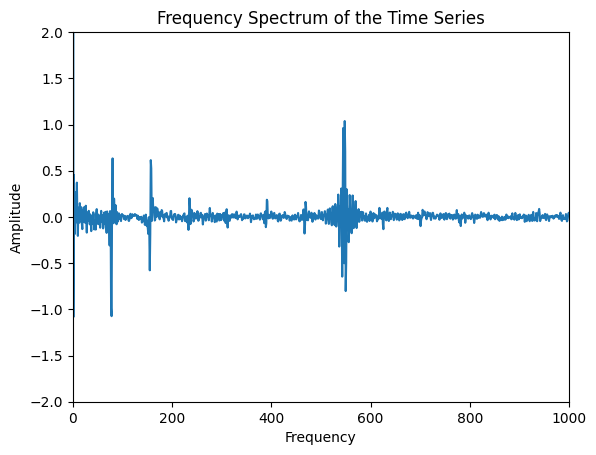

78.125
273.4375
1640.625


In [16]:
plt.plot(fft)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of the Time Series')
plt.xlim(0, 1000)
plt.ylim(-2, 2)
plt.show()
print(len(X)/24/7)
print(len(X)/24/2)
print(len(X)/8)
# Peaks at 82, 165, 580, 1155, 1735, 2890, 

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def ridge_regression_pipeline(X, y, test_size=0.2, random_state=42, alphas=None, cv=5, plot_results=True):
    """
    Complete pipeline for Ridge regression with cross-validation.
    
    Parameters:
    -----------
    X : array-like or pd.DataFrame
        Features matrix
    y : array-like
        Target variable
    test_size : float, default=0.2
        Proportion of data to use for testing
    random_state : int, default=42
        Random state for reproducibility
    alphas : array-like, default=None
        Array of alpha values to try. If None, defaults to [0.1, 1.0, 10.0, 100.0]
    cv : int, default=5
        Number of cross-validation folds
    plot_results : bool, default=True
        Whether to plot predictions vs actual values
        
    Returns:
    --------
    dict : Dictionary containing model, predictions, and evaluation metrics
    """
    # Set default alphas if not provided
    alphas = np.array([1e5])
    if alphas is None:
        alphas = np.logspace(2, 5, 4)
    
    # Convert to numpy arrays if they're pandas objects
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.values
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.values.ravel()

    print(X.shape)
    print(y.shape)

    length = len(X)
    X_train = X[:int(length*0.8)]
    y_train = y[:int(length*0.8)]
    X_test = X[int(length*0.8):]
    y_test = y[int(length*0.8):]
    
    # Split data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=test_size, random_state=random_state
    # )


    # print(X_train.shape)
    # print(X_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)
    
    # Create a pipeline with standardization and RidgeCV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error'))
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Get the best alpha value
    best_alpha = pipeline.named_steps['ridge'].alpha_
    
    # Create results dictionary
    results = {
        'model': pipeline,
        'best_alpha': best_alpha,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'metrics': {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        },
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    
    # Print results
    print(f"Best alpha: {best_alpha}")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))
        
        # Training set
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Training Set')
        
        # Test set
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Test Set')
        
        plt.tight_layout()
        plt.show()

    predictions = pipeline.predict(X)
    plt.plot(predictions[:, -1])
    plt.plot(y[:, -1])
    plt.show()
    
    return results, predictions, pipeline

(13125, 7399)
(13125, 745)
Best alpha: 100000.0
Training MSE: 0.0000
Test MSE: 0.0000
Training R²: 0.8749
Test R²: 0.5536


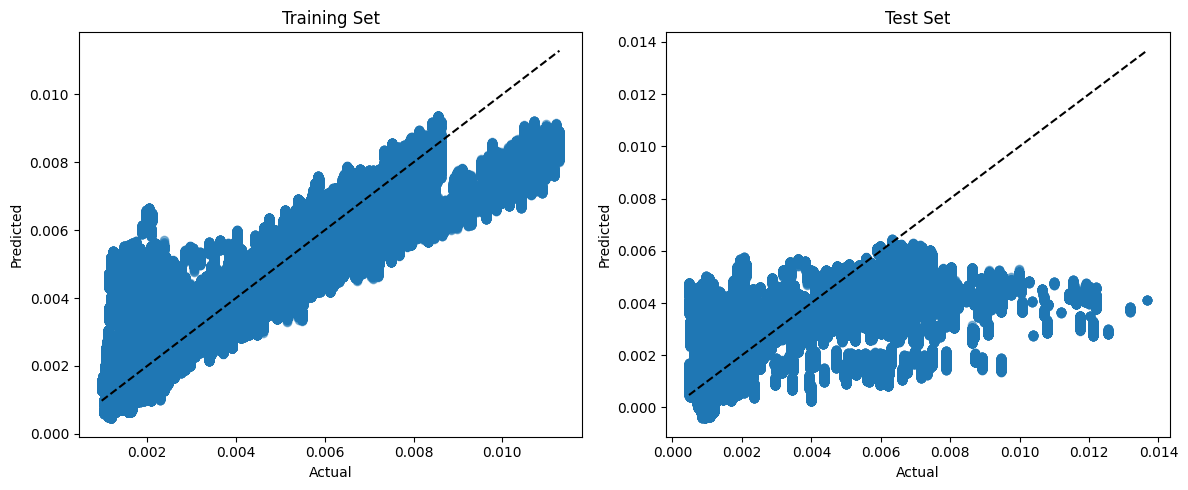

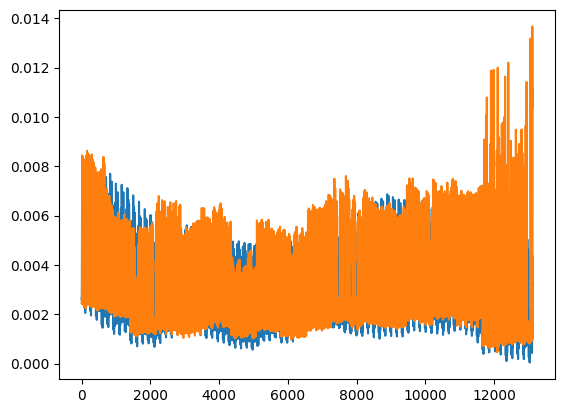


Feature coefficients:
Feature 99: 0.0000
Feature 100: 0.0000
Feature 101: 0.0000
Feature 267: 0.0000
Feature 268: 0.0000
Feature 269: 0.0000
Feature 435: 0.0000
Feature 436: 0.0000
Feature 603: 0.0000
Feature 604: 0.0000
Feature 605: 0.0000
Feature 771: 0.0000
Feature 772: 0.0000
Feature 939: 0.0000
Feature 940: 0.0000
Feature 1107: 0.0000
Feature 1108: 0.0000
Feature 1276: 0.0000
Feature 1444: 0.0000
Feature 1482: 0.0000
Feature 1483: 0.0000
Feature 1484: 0.0000
Feature 1651: 0.0000
Feature 1652: 0.0000
Feature 1819: 0.0000
Feature 1820: 0.0000
Feature 1987: 0.0000
Feature 1988: 0.0000
Feature 2155: 0.0000
Feature 2156: 0.0000
Feature 2323: 0.0000
Feature 2491: 0.0000
Feature 2659: 0.0000


In [5]:
# Run the pipeline
# print(X)
# print(y)
results, predictions, pipeline = ridge_regression_pipeline(X, y)

# Access the trained model
model = results['model']

print("\nFeature coefficients:")
for i, coef in enumerate(model.named_steps['ridge'].coef_[-1]):
    if coef > 1e-5:
        print(f"Feature {i+1}: {coef:.4f}")

(745, 7399)
Feature 1: 0.0000
Feature 2: 0.0000
Feature 74: 0.0000
Feature 75: 0.0000
Feature 76: 0.0000
Feature 77: 0.0000
Feature 78: 0.0000
Feature 90: 0.0000
Feature 91: 0.0000
Feature 92: 0.0000
Feature 93: 0.0000
Feature 95: 0.0000
Feature 96: 0.0000
Feature 97: 0.0000
Feature 98: 0.0000
Feature 99: 0.0000
Feature 100: 0.0000
Feature 101: 0.0000
Feature 102: 0.0000
Feature 103: 0.0000
Feature 104: 0.0000
Feature 105: 0.0000
Feature 106: 0.0000
Feature 107: 0.0000
Feature 108: 0.0000
Feature 109: 0.0000
Feature 110: 0.0000
Feature 122: 0.0000
Feature 123: 0.0000
Feature 124: 0.0000
Feature 125: 0.0000
Feature 126: 0.0000
Feature 133: 0.0000
Feature 134: 0.0000
Feature 242: 0.0000
Feature 243: 0.0000
Feature 244: 0.0000
Feature 245: 0.0000
Feature 246: 0.0000
Feature 258: 0.0000
Feature 259: 0.0000
Feature 260: 0.0000
Feature 261: 0.0000
Feature 263: 0.0000
Feature 264: 0.0000
Feature 265: 0.0000
Feature 266: 0.0000
Feature 267: 0.0000
Feature 268: 0.0000
Feature 269: 0.0000
Featur

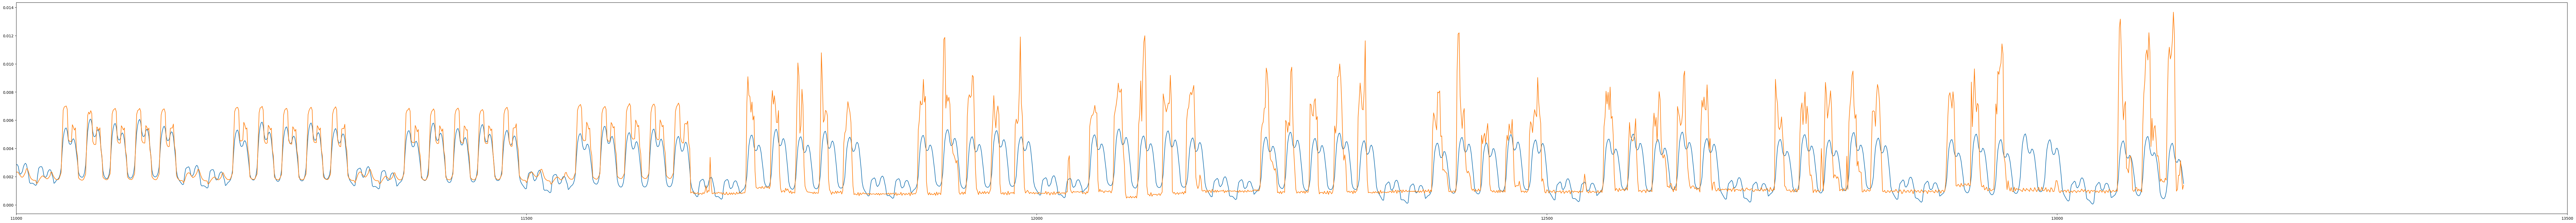

0.25683154976772177


In [6]:
# Print feature importances (coefficients)
print(model.named_steps['ridge'].coef_.shape)
fig = plt.figure(figsize=(120, 10))


good_features = {}
for j in [0]: # range(model.named_steps['ridge'].coef_.shape[0]):
    for i, coef in enumerate(model.named_steps['ridge'].coef_[-j-1]):
        if coef > 1e-8:
            if i+1 in good_features:
                good_features[i+1] += coef
            else:
                good_features[i+1] = coef
            print(f"Feature {i+1}: {coef:.4f}")
print(len(good_features.keys()))
sorted_items = sorted(good_features.items(), key=lambda item: item[1])[::-1]
print(sorted_items)
plt.xlim(11000, 13500)
plt.plot(predictions[:, -1])
plt.plot(y[:, -1])
plt.show()
print(np.mean((np.abs(predictions[:, -1] - y[:, -1]))/y[:, -1]))
# np.save('predictions.npy', predictions)
# np.save('y.npy', y)

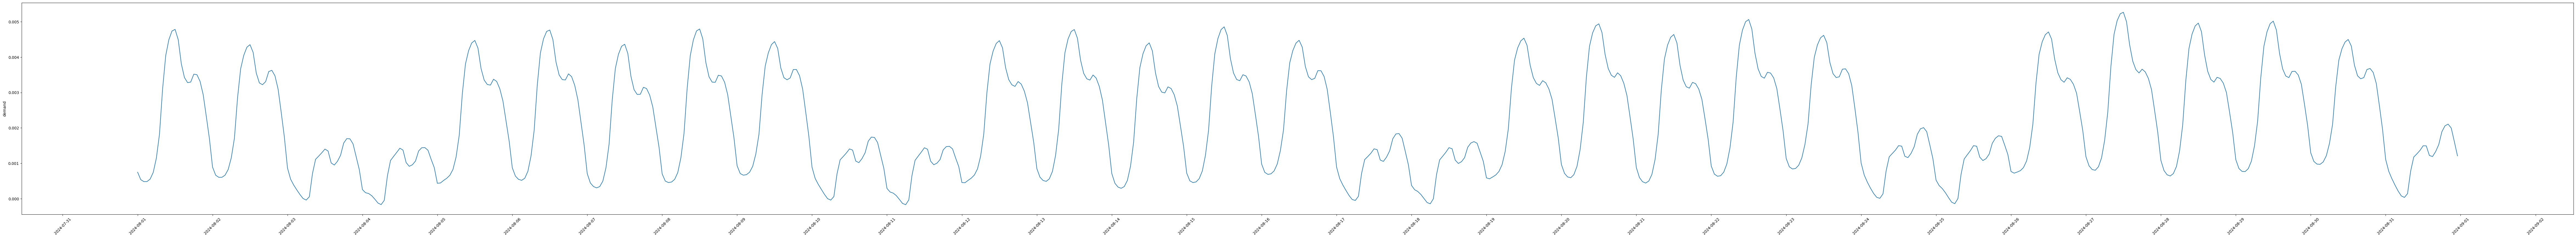

In [13]:
import matplotlib.dates as mdates

date_range = pd.date_range(start='2024-08-01', end='2024-08-31 23:00', freq='h')
fig = plt.figure(figsize=(120, 10))
plt.plot(date_range, pipeline.predict(X_predict)[:, -1])

# Set major ticks every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate for readability
plt.xticks(rotation=45)

# Improve label visibility
plt.xticks(rotation=45)
plt.ylabel('demand')
plt.show()

In [ ]:
from tqdm import tqdm

import warnings
import pandas as pd

from pandas.errors import PerformanceWarning

# Suppress that specific PerformanceWarning
warnings.simplefilter(action="ignore", category=PerformanceWarning)

for country in ['ES', 'IT']:
    # Loading data and features
    Xs, ys, times, customer_ids = get_data(country, demand=[i for i in range(1, 1*24*365//12+1)]+[i for i in range(11*24*365//12+1, 24*365+1)], temp=[0] + [-i-1 for i in range(31*24)], spv=[0] + [-i-1 for i in range(31*24)], rollout_values=[-i-1 for i in range(31*24)], n_futures=31*24)

    new_predictions = []

    for i in tqdm(range(len(Xs))):
        X = Xs[i]  # Assuming X is a 2D numpy array
        y = ys[i]  # Reshaping y to be a 2D column vector

        X_predict = X[len(y):]
        X = X[:len(y)]
        results, predictions, pipeline = ridge_regression_pipeline(X, y)

        # Access the trained model
        model = results['model']
        
        new_predictions.append(model.predict(X_predict)[:, -1])

    final = pd.DataFrame({"DATETIME": pd.date_range(start=pd.Timestamp("2024-08-01 00:00:00"), end=pd.Timestamp("2024-08-31 23:00:00"), freq="h")})
    for i, pred in enumerate(new_predictions):
        final[f'VALUEMWHMETERINGDATA_customer{country}_{customer_ids[i]}'] = pred
    print(final)
    final.to_csv(f'predictions_{country}.csv', index=False, sep=",")
        



 77%|███████▋  | 75/98 [04:20<01:16,  3.32s/it]

In [7]:
# Assuming get_data is a function that returns the data in the correct format.
Xs, ys = get_data('ES', [1])

X = Xs[0]  # Assuming X is a 2D numpy array
y = ys[0].reshape(-1, 1)  # Reshaping y to be a 2D column vector

split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

# Automatically find the best SARIMA order using auto_arima
stepwise_model = auto_arima(y_train,
                             exogenous=X_train,
                             seasonal=True,
                             m=7 * 24,  # weekly seasonality, assuming hourly data for a week
                             stepwise=True,
                             suppress_warnings=True,
                             error_action="ignore",
                             trace=True)

# Extract the best order and seasonal order
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order

# Fit SARIMAX model using the best order and seasonal order
model = SARIMAX(y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Forecast
forecast = results.predict(start=len(X_train), end=len(X_train) + len(y_test) - 1, exog=X_test)

# Evaluate the model
mse = mean_squared_error(y_test, forecast)
print(f"Test MSE: {mse:.2f}")

(22626, 11)
(22626, 4)


ValueError: too many values to unpack (expected 2)

/Users/vimohr/ETH_Datathon_2025/utils.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(start=historical_data.index.min(),
/Users/vimohr/ETH_Datathon_2025/utils.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(start=historical_data.index.min(),


False False
               0      1    2            3     4         5         6   \
0        0.001696  0.004  0.0     0.000000   9.6  0.001764  0.001548   
1        0.001648  0.004  0.0     0.000000   9.5  0.001696  0.001484   
2        0.001608  0.004  0.0     0.000000   9.1  0.001648  0.001460   
3        0.001584  0.004  0.0     0.000000   8.8  0.001608  0.001448   
4        0.001584  0.004  0.0     0.000000   8.5  0.001584  0.001476   
...           ...    ...  ...          ...   ...       ...       ...   
1211061  0.039328  0.029  0.0  9875.634729  32.6  0.040328  0.039328   
1211062  0.039328  0.028  0.0  5074.263796  31.2  0.039328  0.039328   
1211063  0.039328  0.027  0.0   269.250233  29.3  0.039328  0.039328   
1211064  0.039328  0.026  0.0     0.000000  27.8  0.039328  0.039328   
1211065  0.040328  0.026  0.0     0.000000  26.8  0.039328  0.040328   

               7         8     9     10    11    12            13  \
0        0.001436  0.001476   9.7  10.3  10.3   8.9   

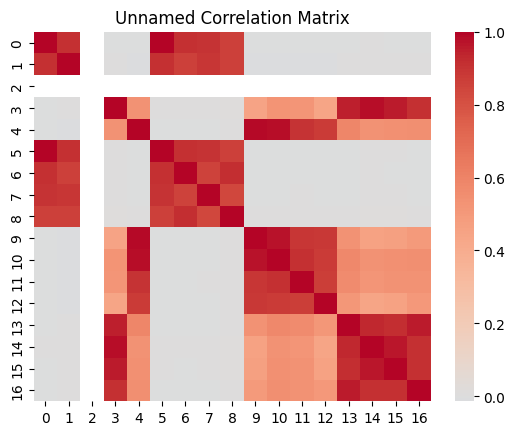

In [ ]:
Xs, ys = get_data('ES')

X = np.vstack([x for x in Xs])
y = np.hstack([y for y in ys])

print(np.isnan(X).any(), np.isnan(y).any())
dX = pd.DataFrame(X)
dy = pd.DataFrame(y)

print(dX)
corr_matrix = dX.corr()

print(corr_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Unnamed Correlation Matrix")
plt.show()


In [ ]:
# Define target and exogenous variables
y = df['demand']
exog = df[['temperature', 'holiday', 'production', 'demand_lag1', 'demand_lag7']]

# Train-test split (e.g., last 20% as test)
split_idx = int(len(df) * 0.8)
y_train, y_test = y[:split_idx], y[split_idx:]
exog_train, exog_test = exog[:split_idx], exog[split_idx:]

# Automatically find best SARIMA order using auto_arima
stepwise_model = auto_arima(y_train,
                             exogenous=exog_train,
                             seasonal=True,
                             m=7,  # weekly seasonality
                             stepwise=True,
                             suppress_warnings=True,
                             error_action="ignore",
                             trace=True)

# Extract best order and seasonal order
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order

# Fit SARIMAX model
model = SARIMAX(y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Forecast
forecast = results.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)

# Evaluation
mse = mean_squared_error(y_test, forecast)
print(f"Test MSE: {mse:.2f}")

In [ ]:
# Plot results
plt.figure(figsize=(14,6))
plt.plot(y_train[-60:], label='Train')
plt.plot(y_test, label='Test')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Energy Demand Forecast")
plt.show()